<h1> Segmenting and Clustering Neighbourhoods in Cape Town, South Africa </h1>

<h2> Overview </h2>

This notebook provides is supplementary to the "Exploration, segmentation and clustering neighbourhoods in Cape Town, South Africa" report included in this repository.
The report provides the introduction, data utilised, methodology, results and discussion as well as conclusions related to the problem statement.
Please note that the report and the supplementary notebook is the final submission for completion of the IBM Data Science Professional Certificate. Further details on the program can be found here: [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science).

This project in particular required demonstration of:
- webscraping capabilities
- utilisation of pandas dataframes
- geocoding capabilities
- utilisation of [Foursquare API](https://developer.foursquare.com/docs/places-api/) to retrieve location data
- data analysis utilisating K-means clustering technique

The project submission problem statement is as follows:
"The owners of a popular Italian Bistro in Johannesburg wants to branch out to Cape Town, but is unsure where would be a good location to do so. Can location data in Cape Town provide some insight?"

There are many factors to consider when assessing whether a new business will be feasible at a certain location (market trends, policy and legal aspects, financial analysis, location demographics etc), however for the purpose of this study (and due to feature data constraints), the following will be considered in addressing the business problem due to data limitations for Cape Town, South Africa:

- Amount of food venues listed on the Foursquare database for Cape Town and their geographical location.
- Amount and geographical location of food venues categorised as 'Italian Restaurant' on the Foursquare database for Cape Town.
- Are there major dissimilarities between areas (that have 3 or more food venues registered) based on types of venues in the food categories located in each area?
- Amount and geographical location of suburbs that have less than 3 food venues registered on the Foursquare database for Cape Town.

<h2> Import Required Libraries </h2>

In [1]:
import requests
from bs4 import BeautifulSoup

import numpy as np

from time import sleep
from random import randint

import pandas as pd

import geocoder
from geopy.geocoders import Nominatim

import folium

import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import sklearn.utils
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

<h2> Web Scraping and Dataframe Creation </h2>

Please take care when webscraping. These [responsible web scraping tips](https://www.scrapehero.com/how-to-prevent-getting-blacklisted-while-scraping/) will be useful.

In [ ]:
postc_url = 'https://www.southafricapostcode.com/location/western-cape/city-of-cape-town/'

The table of interest on the website contains postcodes for all locations in Cape Town. However, it spans across 64 pages. Getting blocked is highly likely when performing webscraping on this website and the sleep function from the time module has thus been utilised to cause a delay time between requests for each page. Since there are 64 requests and a timer between each one, the code takes between 11 and 21 minutes to execute. To avoid having to webscrape the site again, the data was saved to a CSV file for future use.

Note the csv file associated with the code below is utilised throughout the rest of the notebook to avoid scraping the webpage continuously. 
If the viewer is attempting to replicate the data retrieval and analysis, it is recommended that the below code is run only once and the CSV file with the information is utilised from that point onward. Alternative the csv file provided in the repository can be loaded directly without running the webscraping code.

In [ ]:
# create main cpt_data pandas dataframe
cpt_data = pd.DataFrame(columns=["Location", "Postcode"])

# webscraping and add to dataframe

pages = np.arange(1, 65)

for page in pages:
    next_page = requests.get(postc_url + str('?page=') + str(page))
    soup = BeautifulSoup(next_page.text, 'html5lib')
    tables = soup.findAll('table')
    sleep(randint(10,20))  # please increase this timer if you get list index error
  
    for row in tables[0].tbody.find_all("tr"):
        col = row.find_all("td")
        if (col != []):
            location = col[0].text
            postal_code = col[4].text
            cpt_data = cpt_data.append({"Location":location, "Postcode":postal_code,}, ignore_index=True)

In [ ]:
# export to csv
# cpt_data.to_csv('1_locations_cpt.csv')

In [2]:
# read a csv into a pandas dataframe (if you restarted your notebook and utilising the csv file going forward)
cpt_data = pd.read_csv('1_locations_cpt.csv', index_col=0)

<h3> WebScraped Data Exploration </h3>

In [3]:
# observe the data
print("Shape of the dataframe is: ", cpt_data.shape)
print("First five rows of the dataframe: ")
cpt_data.head()

Shape of the dataframe is:  (1265, 2)
First five rows of the dataframe: 


Location  Postcode
0      Admirals Hill      7798
1          Adriaanse      7490
2             Airlie      7806
3       Airport City      7490
4  Airport Industria      7490

<h2> Geocoding </h2>

The geocoder library was utilised to retrieve latitude and longitude coordinates. Geocoder is not always successful at retrieving all the coordinates in a single attempt, therefore a while loop was used to repeat the request until all the data has been retrieved. The code takes approximately 60 minutes to execute. It is recommended that one runs this code only once and then use the csv file from that point onward. If you are a viewer, you are welcome to use the provided csv file instead of repeating the request in the code below.

In [ ]:
locations_cpt = cpt_data['Location'].tolist()

In [ ]:
latitudes = []
longitudes = []

In [ ]:
for location in locations_cpt:
    
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        
        g = geocoder.arcgis(f'{location}, Cape Town, South Africa')
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        latitudes.append(latitude)
        longitudes.append(longitude)
        sleep(randint(1,3))

In [ ]:
len(latitudes)

In [ ]:
# add the latitude and longitude columns with respective list data to the dataframe
cpt_data['Latitude'] = latitudes
cpt_data['Longitude'] = longitudes

In [ ]:
# export to csv
# cpt_data.to_csv('2_latlongs_cpt.csv')

In [4]:
# read in csv again to avoid having re-execute geolocation retrieval code
cpt_data = pd.read_csv('2_latlongs_cpt.csv', index_col=0)

<h2> Geolocation Data Exploration </h2>

In [5]:
cpt_data.head()


Location  Postcode   Latitude  Longitude
0      Admirals Hill      7798 -34.069507  18.559225
1          Adriaanse      7490 -33.939550  18.585440
2             Airlie      7806 -34.038710  18.435080
3       Airport City      7490 -33.978170  18.591080
4  Airport Industria      7490 -33.958700  18.589430

In [6]:
# drop postcode as not necessary
cpt_data.drop(labels='Postcode', axis=1, inplace=True)

In [7]:
cpt_data.isnull().sum()

Location     0
Latitude     0
Longitude    0
dtype: int64

In [8]:
cpt_data.shape

(1265, 3)

In [9]:
cpt_data.head()

Location   Latitude  Longitude
0      Admirals Hill -34.069507  18.559225
1          Adriaanse -33.939550  18.585440
2             Airlie -34.038710  18.435080
3       Airport City -33.978170  18.591080
4  Airport Industria -33.958700  18.589430

<h3> Retrieve only Cape Town coordinates using the geopy library </h3>

In [10]:
# get the geographical coordinates of Cape Town 
address = 'Cape Town, Cpt'

geolocator = Nominatim(user_agent="cpt_explorer")
location_cpt = geolocator.geocode(address)
latitude = location_cpt.latitude
longitude = location_cpt.longitude
print('The geograpical coordinates of Cape Town are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Cape Town are -33.928992, 18.417396.


<h2> Map of Cape Town with suburbs in the dataset imposed as markers </h2>

In [11]:
# create map of Cape Town using latitude and longitude values
map_cpt = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map retrieved from geocoder
for lat, lng, location_1 in zip(cpt_data['Latitude'], cpt_data['Longitude'], cpt_data['Location']):
    label = '{}'.format(location_1)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cpt)
# map_cpt.save("3_map_cpt_suburbs_all.html")

In [12]:
map_cpt

<h2> Use FourSquare API to retrieve venue data for each suburb </h2>

Foursquare developer credentials are required to make calls. Credentials are saved in a local JSON file and loaded into a dictionary to avoid revealing credentials when publishing. Viewers will not be able to reproduce this section of code without a personal account. If viewers have a personal account, credentials can be pasted in directly as opposed to storing in a JSON file or a JSON file can be created and stored locally and loaded in as below. Alternatively, viewers can skip over this section of code and load the data from the provided csv file in the next section.

In [ ]:
with open(r'Foursquare.json') as f:
    data = json.load(f)
    fsqr_creds = {'CLIENT_ID': data[0]['CLIENT_ID'], 'CLIENT_SECRET': data[0]['CLIENT_SECRET'], 'VERSION': data[0]['VERSION']}

In [ ]:
LIMIT = 50  # default fsquare limit
RADIUS = 500  # within 500 m of specified location

Function to get venue details using food categoryId as a criteria. Note that there are call limits associated with different account types. A user is also limited to certain types of calls depending on their account. Please go through foursquare documentation to understand these limitations.

In [ ]:
def getNearbyVenues(locations, latitudes, longitudes, radius=RADIUS):
    
    food_venues_ls=[]
    for loca, lat, lng in zip(locations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            fsqr_creds['CLIENT_ID'], 
            fsqr_creds['CLIENT_SECRET'], 
            fsqr_creds['VERSION'], 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        food_venues_ls.append([(
            loca, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in food_venues_ls for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# cat_ID = '4d4b7105d754a06374d81259'  # food category id code in foursquare
cpt_food_venues = getNearbyVenues(locations=cpt_data['Location'],
                                   latitudes=cpt_data['Latitude'],
                                   longitudes=cpt_data['Longitude'],
                                  )

In [ ]:
# export to csv
# cpt_food_venues.to_csv("4_cpt_food_venues.csv")

<h2> Explore Food Venue Data </h2>

In [13]:
cpt_food_venues = pd.read_csv("4_cpt_food_venues.csv", index_col=0)

In [92]:
print(f'The shape of the dataframe is {cpt_food_venues.shape}')
cpt_food_venues.head()

The shape of the dataframe is (3587, 7)


Location  Location Latitude  Location Longitude  \
0  Castle Rock          -34.23301            18.47351   
1  Scarborough          -34.19834            18.37602   
2  Scarborough          -34.19834            18.37602   
3  Scarborough          -34.19834            18.37602   
4  Scarborough          -34.19834            18.37602   

                        Venue Name  Venue Latitude  Venue Longitude  \
0  Black Marlin Seafood Restaurant      -34.230116        18.471356   
1                       Camel Rock      -34.197126        18.375143   
2                     The Hub Café      -34.196884        18.375010   
3       Foragers Deli & Wholefoods      -34.196880        18.374964   
4                 Whole Earth Café      -34.195824        18.373886   

       Venue Category  
0  Seafood Restaurant  
1  Seafood Restaurant  
2         Coffee Shop  
3     Organic Grocery  
4         Coffee Shop

In [15]:
cpt_food_venues.shape

(11041, 7)

In [16]:
# extract unique venue categories
venue_cats = set(cpt_food_venues['Venue Category'])

In [17]:
print(f'{len(venue_cats)} unique food categories')

134 unique food categories


In [18]:
cpt_food_venues = cpt_food_venues.sort_values(['Location Latitude', 'Location Longitude'], ascending=True, ignore_index = True)

In [19]:
cpt_food_venues.head()

Location  Location Latitude  Location Longitude  \
0    Castle Rock          -34.23301            18.47351   
1  Millers Point          -34.23142            18.47592   
2    Scarborough          -34.19834            18.37602   
3    Scarborough          -34.19834            18.37602   
4    Scarborough          -34.19834            18.37602   

                        Venue Name  Venue Latitude  Venue Longitude  \
0  Black Marlin Seafood Restaurant      -34.230116        18.471356   
1  Black Marlin Seafood Restaurant      -34.230116        18.471356   
2                       Camel Rock      -34.197126        18.375143   
3                     The Hub Café      -34.196884        18.375010   
4       Foragers Deli & Wholefoods      -34.196880        18.374964   

       Venue Category  
0  Seafood Restaurant  
1  Seafood Restaurant  
2  Seafood Restaurant  
3         Coffee Shop  
4     Organic Grocery

Since food venue locations were retrieved in a 500 m range, there will be overlap. Suburbs that overlap within a 500 m range is likely to be similar to one another, therefore only one of these locations are required for the analysis. Overlap can be identified if the food venue retrieved from the Foursquare database has exactly the same venue latitude and venue longitude values.

In [20]:
cpt_food_venues.drop_duplicates(subset=['Venue Latitude', 'Venue Longitude'], ignore_index=True, inplace=True)

In [21]:
cpt_food_venues.shape

(3587, 7)

In [22]:
cpt_food_venues.head()

Location  Location Latitude  Location Longitude  \
0  Castle Rock          -34.23301            18.47351   
1  Scarborough          -34.19834            18.37602   
2  Scarborough          -34.19834            18.37602   
3  Scarborough          -34.19834            18.37602   
4  Scarborough          -34.19834            18.37602   

                        Venue Name  Venue Latitude  Venue Longitude  \
0  Black Marlin Seafood Restaurant      -34.230116        18.471356   
1                       Camel Rock      -34.197126        18.375143   
2                     The Hub Café      -34.196884        18.375010   
3       Foragers Deli & Wholefoods      -34.196880        18.374964   
4                 Whole Earth Café      -34.195824        18.373886   

       Venue Category  
0  Seafood Restaurant  
1  Seafood Restaurant  
2         Coffee Shop  
3     Organic Grocery  
4         Coffee Shop

In [23]:
# get amount of food venues retrieved for each location
cpt_food_venues_count = cpt_food_venues.groupby(['Location'], sort=False).count()

In [24]:
cpt_food_venues_count.head()

Location Latitude  Location Longitude  Venue Name  \
Location                                                          
Castle Rock                   1                   1           1   
Scarborough                   5                   5           5   
The Boulders                  5                   5           5   
Seaforth                      1                   1           1   
Simon's Town                 36                  36          36   

              Venue Latitude  Venue Longitude  Venue Category  
Location                                                       
Castle Rock                1                1               1  
Scarborough                5                5               5  
The Boulders               5                5               5  
Seaforth                   1                1               1  
Simon's Town              36               36              36

cpt_food_venues_count.shape

In [25]:
# keep only relevant column
cpt_food_venues_count = cpt_food_venues_count[cpt_food_venues_count.columns[0:1]]

In [26]:
# rename column
cpt_food_venues_count = cpt_food_venues_count.rename(columns = {'Location Latitude': 'Venues'})

In [27]:
cpt_food_venues_count.head() # max of 100 venues can be retrieved per API call

Venues
Location            
Castle Rock        1
Scarborough        5
The Boulders       5
Seaforth           1
Simon's Town      36

In [28]:
# how many locations have less than 2 food venues retrieved for that location
cpt_few_food = cpt_food_venues_count[cpt_food_venues_count['Venues'] < 3 ]
cpt_few_food.shape

(254, 1)

In [29]:
# do we have missing values?
cpt_food_venues.isnull().values.any()

False

<h3> Explore Italian Restaurants in Cape Town </h3>

In [30]:
is_Italian =  cpt_food_venues['Venue Category'] == "Italian Restaurant"
is_ItalianDF = cpt_food_venues[is_Italian]

In [31]:
# how many Italian restaurants are in the dataset
is_ItalianDF = is_ItalianDF.reset_index()
is_ItalianDF.drop(labels = 'index', axis=1, inplace=True)

In [32]:
is_ItalianDF.shape

(118, 7)

In [33]:
# map the Italian restaurants

# add markers to map retrieved from geocoder
for lat, lng, name in zip(is_ItalianDF['Venue Latitude'], is_ItalianDF['Venue Longitude'], is_ItalianDF['Venue Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#fa8072',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cpt)  
    
map_cpt.save('5_map_cpt_Italian.html')

In [34]:
map_cpt

<h2> One Hot Encoding on Venue Category </h2>

<h3>Data Preparation </h3>
There are 254 locations with less than 3 food venues retrieved as seen previously. It will make for better clustering if there are at least 3 food venues per suburb. So the suburbs with < 3 venues can be discarded. The rest of the suburbs can be used for clustering analysis.

In [35]:
cpt_food_venues.head()

Location  Location Latitude  Location Longitude  \
0  Castle Rock          -34.23301            18.47351   
1  Scarborough          -34.19834            18.37602   
2  Scarborough          -34.19834            18.37602   
3  Scarborough          -34.19834            18.37602   
4  Scarborough          -34.19834            18.37602   

                        Venue Name  Venue Latitude  Venue Longitude  \
0  Black Marlin Seafood Restaurant      -34.230116        18.471356   
1                       Camel Rock      -34.197126        18.375143   
2                     The Hub Café      -34.196884        18.375010   
3       Foragers Deli & Wholefoods      -34.196880        18.374964   
4                 Whole Earth Café      -34.195824        18.373886   

       Venue Category  
0  Seafood Restaurant  
1  Seafood Restaurant  
2         Coffee Shop  
3     Organic Grocery  
4         Coffee Shop

In [36]:
# dataframe with locations with at least 3 food venues
cpt_food_venues_more = cpt_food_venues.groupby('Location').filter(lambda x : len(x) > 2)

In [37]:
cpt_food_venues_more.head()

Location  Location Latitude  Location Longitude  \
1  Scarborough          -34.19834            18.37602   
2  Scarborough          -34.19834            18.37602   
3  Scarborough          -34.19834            18.37602   
4  Scarborough          -34.19834            18.37602   
5  Scarborough          -34.19834            18.37602   

                   Venue Name  Venue Latitude  Venue Longitude  \
1                  Camel Rock      -34.197126        18.375143   
2                The Hub Café      -34.196884        18.375010   
3  Foragers Deli & Wholefoods      -34.196880        18.374964   
4            Whole Earth Café      -34.195824        18.373886   
5              The Boat House      -34.197519        18.373134   

       Venue Category  
1  Seafood Restaurant  
2         Coffee Shop  
3     Organic Grocery  
4         Coffee Shop  
5   French Restaurant

In [38]:
cpt_food_venues_more.shape

(3248, 7)

In [39]:
count_cpt_food_venues_more = cpt_food_venues_more.groupby(['Location']).count()

In [40]:
count_cpt_food_venues_more = count_cpt_food_venues_more[count_cpt_food_venues_more.columns[0:1]]

In [41]:
count_cpt_food_venues_more = count_cpt_food_venues_more.rename(columns = {'Location Latitude': 'Venues'})

In [42]:

count_cpt_food_venues_more.head()

Venues
Location          
Albowville      25
Amandaglen       4
Annandale        8
Arauna           6
Area Al         12

<h3> Venues for each category in the dataset </h3>

In [43]:
cpt_food_venue_categories = cpt_food_venues_more.groupby(['Venue Category']).count()

In [44]:
cpt_food_venue_categories = cpt_food_venue_categories[cpt_food_venue_categories.columns[0:1]]

In [45]:
cpt_food_venue_categories = cpt_food_venue_categories.rename(columns = {'Location': 'Venues'}).reset_index()

In [46]:
cpt_food_venue_categories.head()

Venue Category  Venues
0   African Restaurant      55
1       Airport Lounge       1
2  American Restaurant      18
3         Antique Shop       1
4     Arepa Restaurant       2

In [47]:
cpt_food_venue_categories = cpt_food_venue_categories.sort_values(by=['Venues'], ascending=False, ignore_index=True)

In [48]:
cpt_food_venue_categories[0:1]

Venue Category  Venues
0    Coffee Shop     366

In [49]:
cpt_food_venue_categories.head(10)

Venue Category  Venues
0           Coffee Shop     366
1                  Café     355
2            Restaurant     223
3  Fast Food Restaurant     204
4           Pizza Place     198
5    Seafood Restaurant     123
6          Burger Joint     121
7                Bakery     111
8    Italian Restaurant     111
9     Indian Restaurant      85

Coffee Shop and Cafe are most likely the same thing, therefore will be combined in both cpt_food_venues_more and cpt_food_venues_categories dataframes

In [50]:
cpt_food_venues_more.loc[(cpt_food_venues_more['Venue Category'] == 'Coffee Shop', 'Venue Category')] = 'Café'

In [51]:
cpt_food_venues_more.head()

Location  Location Latitude  Location Longitude  \
1  Scarborough          -34.19834            18.37602   
2  Scarborough          -34.19834            18.37602   
3  Scarborough          -34.19834            18.37602   
4  Scarborough          -34.19834            18.37602   
5  Scarborough          -34.19834            18.37602   

                   Venue Name  Venue Latitude  Venue Longitude  \
1                  Camel Rock      -34.197126        18.375143   
2                The Hub Café      -34.196884        18.375010   
3  Foragers Deli & Wholefoods      -34.196880        18.374964   
4            Whole Earth Café      -34.195824        18.373886   
5              The Boat House      -34.197519        18.373134   

       Venue Category  
1  Seafood Restaurant  
2                Café  
3     Organic Grocery  
4                Café  
5   French Restaurant

In [52]:
cpt_food_venue_categories = cpt_food_venues_more.groupby(['Venue Category']).count()

In [53]:
cpt_food_venue_categories = cpt_food_venue_categories[cpt_food_venue_categories.columns[0:1]]

In [54]:
cpt_food_venue_categories = cpt_food_venue_categories.rename(columns = {'Location': 'Venues'}).reset_index()

In [55]:
cpt_food_venue_categories.head()

Venue Category  Venues
0   African Restaurant      55
1       Airport Lounge       1
2  American Restaurant      18
3         Antique Shop       1
4     Arepa Restaurant       2

In [56]:
cpt_food_venue_categories = cpt_food_venue_categories.sort_values(by=['Venues'], ascending=False, ignore_index=True)

In [57]:
cpt_food_venue_categories[0:1]

Venue Category  Venues
0           Café     721

In [58]:
cpt_food_venue_categories.head(10)

Venue Category  Venues
0                  Café     721
1            Restaurant     223
2  Fast Food Restaurant     204
3           Pizza Place     198
4    Seafood Restaurant     123
5          Burger Joint     121
6    Italian Restaurant     111
7                Bakery     111
8     Indian Restaurant      85
9     Fish & Chips Shop      77

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

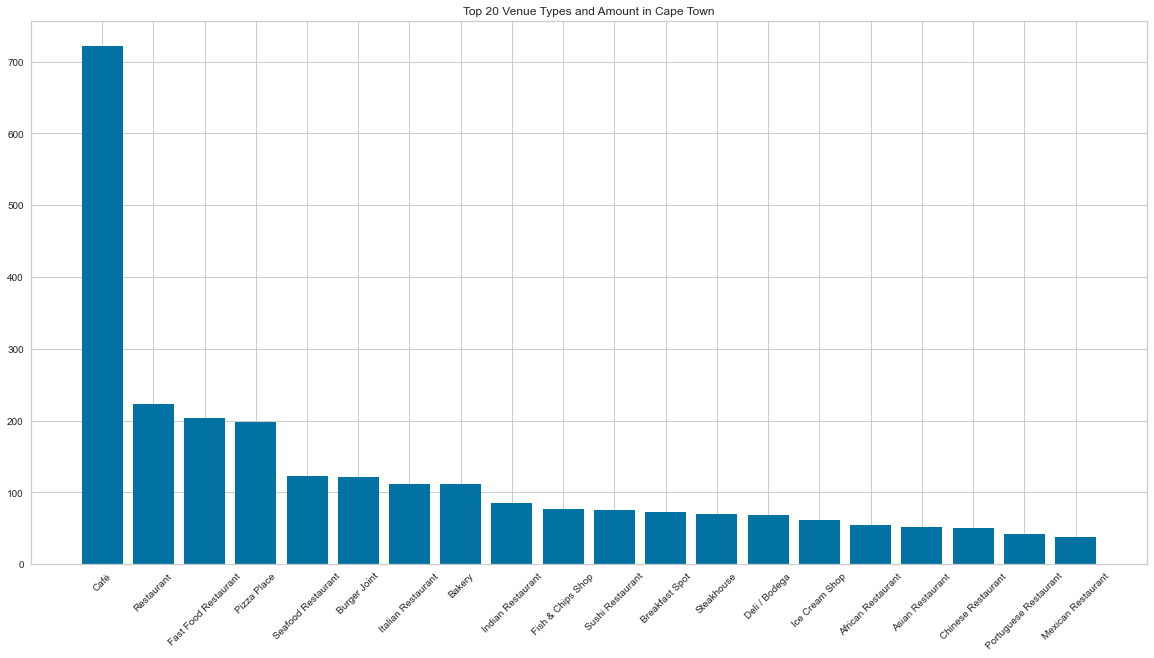

In [59]:
plt.figure(figsize=(20,10))
plt.title("Top 20 Venue Types and Amount in Cape Town")
plt.bar(x=cpt_food_venue_categories['Venue Category'][0:20], height=cpt_food_venue_categories['Venues'][0:20])
plt.xticks(rotation = 45)

In [60]:
# remove categories that appear less than 5 times in the dataset
cpt_food_venues_more = cpt_food_venues_more.groupby('Venue Category').filter(lambda x : len(x) > 4)

In [61]:
cpt_food_venues_more.shape

(3108, 7)

<h3> Perform One Hot Encoding </h3>

In [62]:
# one hot encoding on venue category
cpt_onehot = pd.get_dummies(cpt_food_venues_more[['Venue Category']], prefix="", prefix_sep="")
cpt_onehot.head()

African Restaurant  American Restaurant  Asian Restaurant  BBQ Joint  \
1                   0                    0                 0          0   
2                   0                    0                 0          0   
4                   0                    0                 0          0   
5                   0                    0                 0          0   
6                   0                    0                 0          0   

   Bagel Shop  Bakery  Bar  Bistro  Breakfast Spot  Burger Joint  ...  \
1           0       0    0       0               0             0  ...   
2           0       0    0       0               0             0  ...   
4           0       0    0       0               0             0  ...   
5           0       0    0       0               0             0  ...   
6           0       0    0       0               0             0  ...   

   Sandwich Place  Seafood Restaurant  Snack Place  Steakhouse  \
1               0                   1            0           0   
2               0                   0            0           0   
4               0                   0            0           0   
5               0                   0            0           0   
6               0                   0            0           0   

   Sushi Restaurant  Tapas Restaurant  Tea Room  Thai Restaurant  \
1                 0                 0         0                0   
2                 0                 0         0                0   
4                 0                 0         0                0   
5                 0                 0         0                0   
6                 0                 0         0                0   

   Vegetarian / Vegan Restaurant  Wings Joint  
1                              0            0  
2                              0            0  
4                              0            0  
5                              0            0  
6                              0            0  

[5 rows x 54 columns]

<h3> Reform Dataframe and Explore </h3>

In [63]:
# add postcode to dataframe
cpt_onehot['Location'] = cpt_food_venues_more['Location']

# move location column to the first column
fixed_columns = [cpt_onehot.columns[-1]] + list(cpt_onehot.columns[:-1])
cpt_onehot = cpt_onehot[fixed_columns]

In [64]:
# Group rows by location and by taking the mean of the frequency of occurrence of each category
cpt_grouped = cpt_onehot.groupby('Location').mean().reset_index()

In [65]:
cpt_grouped.shape

(275, 55)

In [66]:
cpt_grouped.head()

Location  African Restaurant  American Restaurant  Asian Restaurant  \
0  Albowville            0.045455                  0.0               0.0   
1  Amandaglen            0.000000                  0.0               0.0   
2   Annandale            0.000000                  0.0               0.0   
3      Arauna            0.000000                  0.0               0.0   
4     Area Al            0.000000                  0.1               0.0   

   BBQ Joint  Bagel Shop  Bakery  Bar  Bistro  Breakfast Spot  ...  \
0        0.0         0.0     0.0  0.0     0.0           0.000  ...   
1        0.0         0.0     0.0  0.0     0.0           0.000  ...   
2        0.0         0.0     0.0  0.0     0.0           0.125  ...   
3        0.0         0.0     0.0  0.0     0.0           0.000  ...   
4        0.0         0.0     0.2  0.0     0.0           0.000  ...   

   Sandwich Place  Seafood Restaurant  Snack Place  Steakhouse  \
0             0.0            0.045455          0.0        0.00   
1             0.0            0.000000          0.0        0.25   
2             0.0            0.000000          0.0        0.00   
3             0.0            0.000000          0.0        0.00   
4             0.1            0.000000          0.0        0.00   

   Sushi Restaurant  Tapas Restaurant  Tea Room  Thai Restaurant  \
0          0.090909               0.0       0.0              0.0   
1          0.000000               0.0       0.0              0.0   
2          0.000000               0.0       0.0              0.0   
3          0.000000               0.0       0.0              0.0   
4          0.000000               0.0       0.0              0.0   

   Vegetarian / Vegan Restaurant  Wings Joint  
0                           0.00     0.045455  
1                           0.25     0.000000  
2                           0.00     0.000000  
3                           0.00     0.000000  
4                           0.00     0.000000  

[5 rows x 55 columns]

<h3> Top 3 venues for each suburb </h3>

In [67]:
# estimate the top 3 food venues for each neighbourhood
# sort the venues in descending order
num_top_venues = 3

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd','th']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
locations_venues_sorted = pd.DataFrame(columns=columns)
locations_venues_sorted['Location'] = cpt_grouped['Location']

for ind in np.arange(cpt_grouped.shape[0]):
    locations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cpt_grouped.iloc[ind, :], num_top_venues)


In [68]:
locations_venues_sorted.head()

Location          1st Most Common Venue 2nd Most Common Venue  \
0  Albowville                           Café      Sushi Restaurant   
1  Amandaglen  Vegetarian / Vegan Restaurant            Food Truck   
2   Annandale                     Restaurant           Pizza Place   
3      Arauna              Fish & Chips Shop  Fast Food Restaurant   
4     Area Al              Fish & Chips Shop                Bakery   

  3rd Most Common Venue  
0    African Restaurant  
1            Steakhouse  
2        Breakfast Spot  
3         Deli / Bodega  
4                  Café

<h2> Clustering the areas of Cape Town </h2>

In [69]:
cpt_grouped_clustering = cpt_grouped.drop('Location', 1)

<h3> Check for optimum amount of clusters using elbow method </h3>

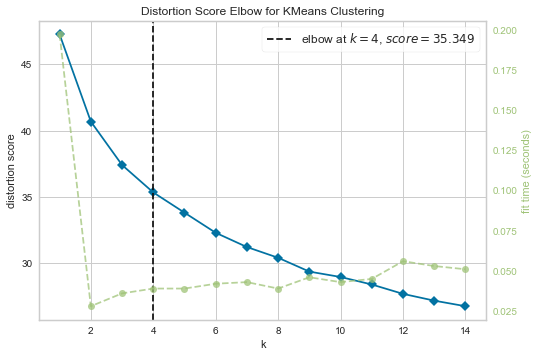

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
# Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15))

visualizer.fit(cpt_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Fit the data to the visualizer

<h3> Set clusters and fit kmeans model </h3>

In [72]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cpt_grouped_clustering)

<h2> Explore the Clusters </h2>

<h3> Merge the results in a new dataframe </h3>

In [73]:
# merge cluster labels as well as the top 3 venues for each neighborhood created earlier.
locations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [74]:
locations_venues_sorted['Cluster Labels'] = kmeans.labels_

In [75]:
cpt_merged = cpt_data  # take the initial DF with the locations, latitudes and longitudes

# merge with cluster data, joining based on location name
cpt_merged = cpt_merged.join(locations_venues_sorted.set_index('Location'), on='Location')

In [76]:
cpt_merged.head()

Location   Latitude  Longitude  Cluster Labels  \
0      Admirals Hill -34.069507  18.559225             NaN   
1          Adriaanse -33.939550  18.585440             NaN   
2             Airlie -34.038710  18.435080             NaN   
3       Airport City -33.978170  18.591080             NaN   
4  Airport Industria -33.958700  18.589430             NaN   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
0                   NaN                   NaN                   NaN  
1                   NaN                   NaN                   NaN  
2                   NaN                   NaN                   NaN  
3                   NaN                   NaN                   NaN  
4                   NaN                   NaN                   NaN

In [77]:
# deal with NaN values
cpt_merged.dropna(inplace=True)

In [78]:
cpt_merged = cpt_merged.drop_duplicates(subset=['Location'], ignore_index=True)

In [79]:
cpt_merged.head()

Location   Latitude  Longitude  Cluster Labels  \
0  Albowville -33.919090  18.421980             2.0   
1  Amandaglen -33.857620  18.663890             3.0   
2   Annandale -33.913933  18.684322             1.0   
3      Arauna -33.873670  18.686120             3.0   
4     Area Al -33.863010  18.519890             1.0   

           1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
0                           Café      Sushi Restaurant    African Restaurant  
1  Vegetarian / Vegan Restaurant            Food Truck            Steakhouse  
2                     Restaurant           Pizza Place        Breakfast Spot  
3              Fish & Chips Shop  Fast Food Restaurant         Deli / Bodega  
4              Fish & Chips Shop                Bakery                  Café

In [80]:
# check if there are null values left
cpt_merged['Cluster Labels'].isnull().values.any()

False

In [81]:
# convert the cluster values to type int, otherwise it can't be mapped
cpt_merged = cpt_merged.astype({"Cluster Labels": int})

In [82]:
cpt_merged.head()

Location   Latitude  Longitude  Cluster Labels  \
0  Albowville -33.919090  18.421980               2   
1  Amandaglen -33.857620  18.663890               3   
2   Annandale -33.913933  18.684322               1   
3      Arauna -33.873670  18.686120               3   
4     Area Al -33.863010  18.519890               1   

           1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
0                           Café      Sushi Restaurant    African Restaurant  
1  Vegetarian / Vegan Restaurant            Food Truck            Steakhouse  
2                     Restaurant           Pizza Place        Breakfast Spot  
3              Fish & Chips Shop  Fast Food Restaurant         Deli / Bodega  
4              Fish & Chips Shop                Bakery                  Café

<h3> Map the clusters </h3>

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cpt_merged['Latitude'], cpt_merged['Longitude'], cpt_merged['Location'], cpt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
# map_clusters.save('6_map_clusters.html')
map_clusters

<h3> View cluster data </h3>

In [85]:
# cluster 1
cluster_1 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 0, cpt_merged.columns[[0] + list(range(4, cpt_merged.shape[1]))]]
print(f'Cluster 1 shape {cluster_1.shape}')
cluster_1.head()

Cluster 1 shape (14, 4)


Location 1st Most Common Venue 2nd Most Common Venue  \
13           Bakoven    African Restaurant        Breakfast Spot   
17  Belgravia Estate            Restaurant      Sushi Restaurant   
24         Bergvliet            Restaurant           Pizza Place   
59       Dido Valley            Restaurant            Steakhouse   
61       Die Wingerd            Restaurant     Convenience Store   

    3rd Most Common Venue  
13   Fast Food Restaurant  
17   Fast Food Restaurant  
24        Thai Restaurant  
59                   Café  
61  Portuguese Restaurant

In [86]:
# cluster 2
cluster_2 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 1, cpt_merged.columns[[0] + list(range(4, cpt_merged.shape[1]))]]
print(f'Cluster 2 shape {cluster_2.shape}')
cluster_2.head()

Cluster 2 shape (137, 4)


Location 1st Most Common Venue 2nd Most Common Venue  \
2          Annandale            Restaurant           Pizza Place   
4            Area Al     Fish & Chips Shop                Bakery   
5      Ascot Village           Pizza Place     Indian Restaurant   
6            Athlone           Pizza Place     Indian Restaurant   
7  Athlone Industria                Bakery      Sushi Restaurant   

  3rd Most Common Venue  
2        Breakfast Spot  
4                  Café  
5        Ice Cream Shop  
6   Fried Chicken Joint  
7           Snack Place

In [87]:
# cluster 3
cluster_3 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 2, cpt_merged.columns[[0] + list(range(4, cpt_merged.shape[1]))]]
print(f'Cluster 3 shape {cluster_3.shape}')
cluster_3.head()

Cluster 3 shape (82, 4)


Location 1st Most Common Venue 2nd Most Common Venue  \
0         Albowville                  Café      Sushi Restaurant   
11  Avondale Gardens                Bakery                  Café   
16      Beach Estate                  Café    African Restaurant   
20          Bellrail                  Café     Indian Restaurant   
21         Bellville                  Café          Burger Joint   

   3rd Most Common Venue  
0     African Restaurant  
11        Breakfast Spot  
16         Deli / Bodega  
20  Fast Food Restaurant  
21  Fast Food Restaurant

In [88]:
# cluster 4
cluster_4 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 3, cpt_merged.columns[[0] + list(range(4, cpt_merged.shape[1]))]]
print(f'Cluster 4 shape {cluster_4.shape}')
cluster_4.head()

Cluster 4 shape (42, 4)


Location          1st Most Common Venue  \
1                 Amandaglen  Vegetarian / Vegan Restaurant   
3                     Arauna              Fish & Chips Shop   
12                  Avonwood                  Deli / Bodega   
19  Bellair Winelands Estate                 Ice Cream Shop   
31                   Bosonia           Fast Food Restaurant   

   2nd Most Common Venue 3rd Most Common Venue  
1             Food Truck            Steakhouse  
3   Fast Food Restaurant         Deli / Bodega  
12          Burger Joint  Fast Food Restaurant  
19     Fish & Chips Shop  Fast Food Restaurant  
31     Indian Restaurant            Food Court